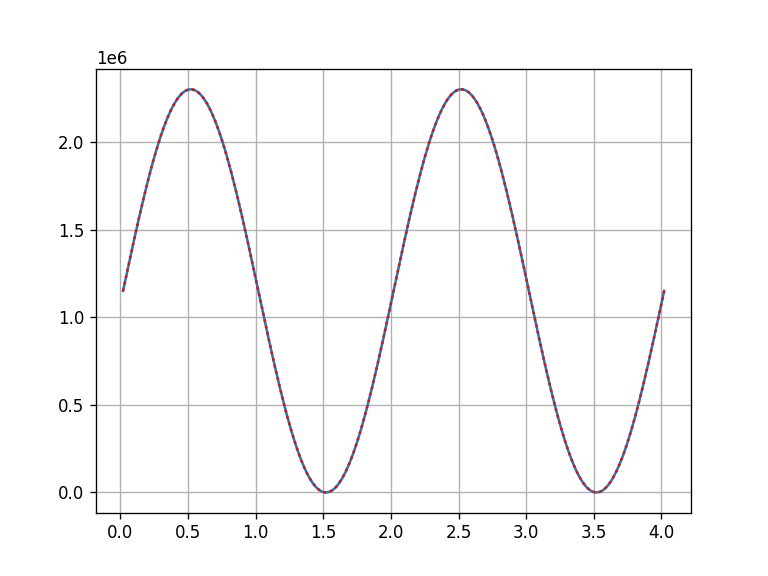

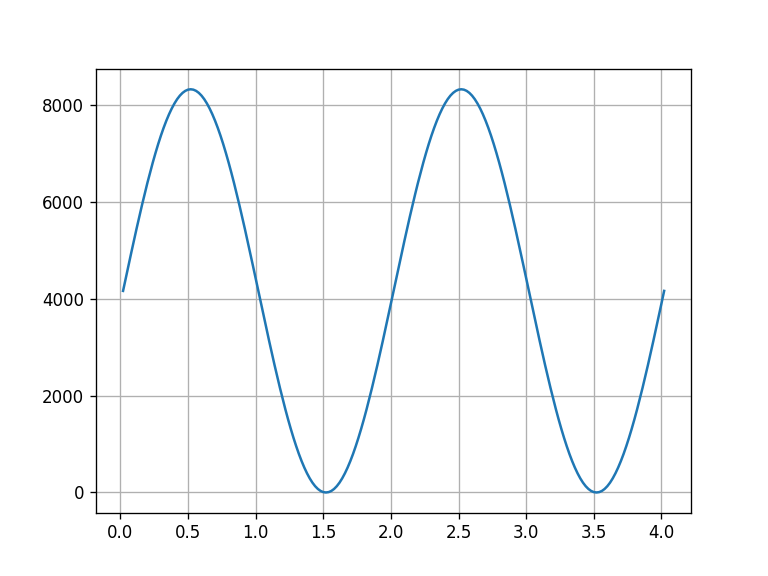

In [3]:
import csv
%matplotlib widget
import matplotlib.pyplot as plt

path = "sinSig.csv"
csv_file = open(path, newline='')
header = next(csv_file)
reader = csv.reader(csv_file)

pwr = []
t = []
pwrInt = []
pwrPcntg = []
for row in reader:
    power = float(row[0])
    time = float(row[1])
    powerInt = int(row[2])
    powerPercentage = int(row[3])
    t.append([time])
    pwr.append([power])
    pwrInt.append([powerInt])
    pwrPcntg.append([powerPercentage])

plt.clf()
plt.close()
plt.figure(dpi = 120)
plt.plot(t, pwr )
plt.plot(t, pwrInt, 'r', linestyle='dotted')
plt.grid()
plt.show()

plt.figure(dpi = 120)
plt.plot(t, pwrPcntg )
plt.grid()
plt.show()

# plt.figure(dpi = 120)
# plt.plot(t, pwrInt)
# # current_values = plt.gca().get_yticks()
# # # using format string '{:.0f}' here but you can choose others
# # plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
# plt.grid()
# plt.show()

# for i in range(len(data) - 1):